In [1]:
#IMPORT necessary libraries
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
#import os
import seaborn as sns

reading data

In [2]:
data= pd.read_excel('sales_bcs.xlsx')
sales_oder= pd.read_excel('sales_bcs.xlsx','Sales Orders Sheet')
customers=pd.read_excel('sales_bcs.xlsx', 'Customers Sheet')
site_location= pd.read_excel('sales_bcs.xlsx','Site Location sheet')
products= pd.read_excel('sales_bcs.xlsx', 'Products_Sheet')
sales_team= pd.read_excel('sales_bcs.xlsx','Sales Team Sheet')

In [3]:
"unique unit cost", len(set(sales_oder['Unit Cost'])),"unique unit price", len(set(sales_oder['Unit Price'])),"unique order number", len(set(sales_oder['OrderNumber']))


('unique unit cost',
 5581,
 'unique unit price',
 664,
 'unique order number',
 7991)

### Data Augementation

In [4]:
#as productid is in object datatype, we add another column for index

products_index = [a for a in range(len(products))]
products['products_index'] = products_index
#products.head()

In [5]:
# marging data in single file

df= sales_oder.join(customers.set_index('_CustomerID'), on= '_CustomerID').join(site_location.set_index('_SiteID'), on= '_SiteID').join(sales_team.set_index('_SalesAM_ID'), on= '_SalesAM_ID').join(products.set_index('products_index'), on='_ProductID', lsuffix='_left', rsuffix='_right', how='left')
#df.head()

In [6]:
# tasks
# adding relevent columns
#add another column for sales
df['totalsales']= (df['Order Quantity']* df['Unit Price'])-df['Discount Applied']

#add another column for months
df['month'] = pd.DatetimeIndex(df['OrderDate']).month
df['Year'] = pd.DatetimeIndex(df['OrderDate']).year

##Calculate profit from each individual sale transaction
df['Profit'] = (df['Unit Price']- df['Unit Cost'])-df['Discount Applied']

#df.head()

In [7]:
#products

In [8]:
#Add Bandwidth purchased from each transaction
df = df.merge(products[['_ProductID','Bandwidth']])
#, left_on = "_ProductID", right_on = "_ProductID", how = "left")

In [9]:
#Add last purchase data in days from
def last_purchase(customer_id, OrderIndex):
    customer_purchase = df.query("_CustomerID == {customer_id}").sort_values(['OrderDate'])
    current_purchase_date = customer_purchase.loc[OrderIndex].OrderDate #current purchase data
    last_purchase_date = customer_purchase.loc[OrderIndex -1]

In [10]:
#Group all prouduct demand by their months
demand = pd.DataFrame()
for item in df['_ProductID'].unique():
    demand[str(item)] = 0

In [11]:
#Uniques months
len(df['_ProductID'].unique())

47

In [16]:
df['Month-Year']= df['OrderDate'].dt.strftime('%Y/%m')
df['Month-Year']

0         2018/05
1         2018/06
2         2018/06
3         2018/06
4         2018/06
           ...   
153074    2020/12
153075    2020/12
153076    2020/12
153077    2020/12
153078    2020/12
Name: Month-Year, Length: 153079, dtype: object

In [17]:
df.loc[(df['Month-Year'] == '2018/05') & (df['_ProductID'] == 1)].OrderNumber.count()

0

In [18]:
prod_demand = {}

for product in list(df['_ProductID'].unique()):
    month_demand = []
    for mo in list(df['Month-Year'].unique()):
        b = df.loc[(df['Month-Year'] == mo) & (df['_ProductID'] == product)].OrderNumber.count() 
        month_demand.append(b)
    prod_demand[product] = month_demand

In [19]:
prod_demand['Month-Year'] = df['Month-Year'].unique()

In [20]:
bv = pd.DataFrame(prod_demand)

<AxesSubplot:xlabel='Month-Year'>

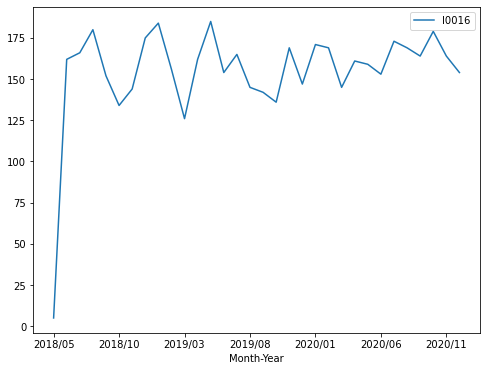

In [21]:
bv.plot.line(x='Month-Year',y=[1], figsize=(8,6))

### data cleaning

In [22]:
df=df.fillna(0)
#df.head()

#### feature engineering

https://github.com/PetraLee2019/Python-Sales-Data-Analysis

In [23]:
# some data are not numerical, we will have to do label incoding
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
#df['SIte Name'] = enc.fit_transform(df['SIte Name'])
df['District'] = enc.fit_transform(df['District'])

df['Product Name'] = df['Product Name'].astype('string')
df['Product Name'] = enc.fit_transform(df['Product Name'])

df['Item/Service Description'] = df['Item/Service Description'].astype('string')
df['Item/Service Description'] = enc.fit_transform(df['Item/Service Description'])
df['Customer Names'] = enc.fit_transform(df['Customer Names'])
df['OrderDate'] = enc.fit_transform(df['OrderDate'])
#df.head()

[Text(0.5, 0, 'OrderDate'),
 Text(1.5, 0, '_SalesAM_ID'),
 Text(2.5, 0, '_CustomerID'),
 Text(3.5, 0, '_SiteID'),
 Text(4.5, 0, '_ProductID_left'),
 Text(5.5, 0, 'Order Quantity'),
 Text(6.5, 0, 'Discount Applied'),
 Text(7.5, 0, 'Unit Price'),
 Text(8.5, 0, 'Unit Cost'),
 Text(9.5, 0, 'Customer Names'),
 Text(10.5, 0, 'District'),
 Text(11.5, 0, 'Product Name'),
 Text(12.5, 0, 'Item/Service Description'),
 Text(13.5, 0, 'totalsales'),
 Text(14.5, 0, 'month'),
 Text(15.5, 0, 'Year'),
 Text(16.5, 0, 'Profit')]

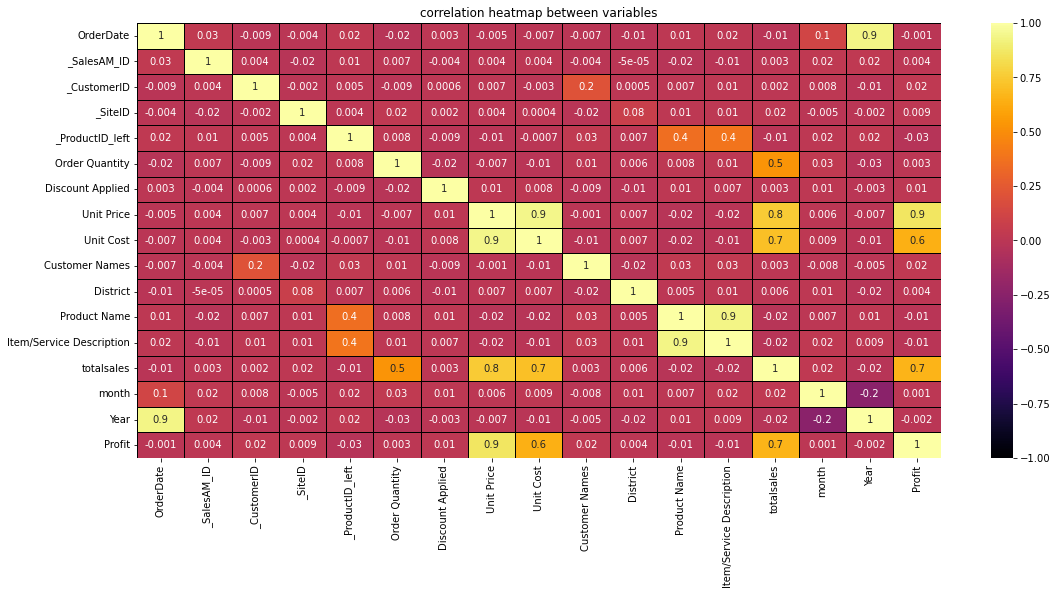

In [24]:
fig = (18,8)
plt.figure(figsize=fig)
heatmap = sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='inferno', linewidths=1, linecolor='Black')
heatmap.set_title('correlation heatmap between variables')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

## data visualization

In [25]:
#best month for sales and how much earned
best_month= df.groupby('month').sum()
#best_month

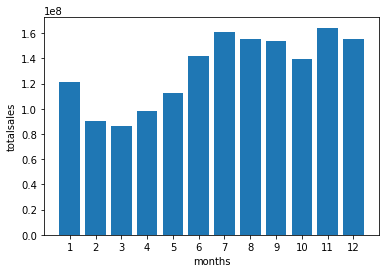

In [26]:
months= range(1,13)
plt.bar(months, best_month['totalsales'])
plt.xticks(months)
plt.ylabel('totalsales')
plt.xlabel('months')
plt.show()

In [27]:
# THE district THAT WAS BEST FOR SALES
best_district= df.groupby('District').sum()
#best_district

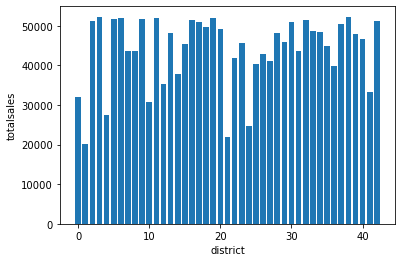

In [28]:
districts= [District for District in df.groupby('District')]
sales= df['totalsales']
X= df['District']
Y= sales
plt.bar(X, Y)
# plt.bar(districts, best_district['sales'])
# plt.xticks(districts, rotation='vertical', size=8)
plt.ylabel('totalsales')
plt.xlabel('district')
plt.show()

In [30]:
df['Product Name'] = df['Product Name'].astype('string')
df['OrderDate'] = df['OrderDate'].astype('string')

daf= df[df['OrderDate'].duplicated(keep=False)]
daf['grouped']= daf.groupby('OrderNumber')['Product Name'].transform(lambda x: ','.join(x))
daf= daf[['OrderNumber','grouped']].drop_duplicates()
daf.head(100)

,OrderNumber,grouped
0,SO - 000101,5
1,SO - 000217,5
2,SO - 000244,5
3,SO - 000248,5
4,SO - 000253,5
...,...,...
95,SO - 0004152,5
96,SO - 0004199,5
97,SO - 0004260,5
98,SO - 0004274,5


## Building the model

#### Predicting future products demand

In [37]:
x = df.drop(["Discount Applied","_ProductID","OrderNumber","OrderDate","Year","Month-Year","_ProductID_right","CurrencyCode","_ProductID_left"], axis="columns")
y = df["_ProductID"]

In [38]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
X_train.dtypes

_SalesAM_ID                   int64
_CustomerID                   int64
_SiteID                       int64
Order Quantity                int64
Unit Price                  float64
Unit Cost                   float64
Customer Names                int32
District                      int32
AM Name                      object
Product Name                 string
Item/Service Description      int32
Bandwidth                    object
totalsales                  float64
month                         int64
Profit                      float64
dtype: object

In [39]:
#df['Bandwidth'] = df['Bandwidth'].astype('int')

In [40]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [42]:
#model.fit(X_train, y_train)

In [ ]:
y_pred=model.predict(X_test)
y_predtrain = model.predict(X_train)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_pred)